$$
\Huge \textbf{Part fine-tuning}
$$


---



# 1) setup

---



In [ ]:
import os
import sys
import glob
from tqdm import tqdm
import random
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import json
from pathlib import Path
from typing import Dict, List, Tuple, Optional
import torchvision.transforms as transforms
from collections import defaultdict
import pickle
from datetime import datetime
import pandas as pd
!rm -rf semantic-correspondence

!git clone https://github.com/MarcotteS/semantic-correspondence.git
import sys
sys.path.append('/content/semantic-correspondence/src')

import fine_tunning.test as ft
import importlib
importlib.reload(ft)
import sys
sys.path.append('/content/semantic-correspondence/src')
import fine_tunning.test as ft
import importlib
importlib.reload(ft)

from fine_tunning.test import CorrespondenceMatcher2
from evaluation import CorrespondenceEvaluator,evaluate_model
from analyzer import ResultsAnalyzer
from correspondence import CorrespondenceMatcher
from models import DINOv2Extractor,DINOv3Extractor,SAMExtractor
from dataset import SPairDataset,denorm,draw_image_with_keypoints,visualize_sample,collate_fn_correspondence

#                                 Data

---




In [ ]:
!wget https://cvlab.postech.ac.kr/research/SPair-71k/data/SPair-71k.tar.gz

ls: cannot access '/content/drive/MyDrive/semantic-correspondance-project/checkpoints': No such file or directory


In [ ]:
!tar -xf SPair-71k.tar.gz

In [15]:
image_size = 512 # Images must be multiples of 14 for DINOv2 or 16 for DINOv3.
dataset = SPairDataset(
        datapath='.',
        split='trn', #change to trn !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        img_size=image_size,
        category='all'
    )

train_loader = DataLoader(
    dataset,
    batch_size=16,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn_correspondence
)

Loading SPair-71k trn annotations...


100%|██████████| 53340/53340 [00:08<00:00, 6036.97it/s]


# Model

---



In [9]:
#extractor = DINOv2Extractor(model_name="dinov2_vitb14")
#!git clone https://github.com/facebookresearch/dinov3.git
#!pip install torchmetrics
#checkpoint_path = "https://dinov3.llamameta.net/dinov3_vitb16/dinov3_vitb16_pretrain_lvd1689m-73cec8be.pth?Policy=eyJTdGF0ZW1lbnQiOlt7InVuaXF1ZV9oYXNoIjoiaHFsdmZ5bThiOTJlaXU2MnNiaTF3eGN0IiwiUmVzb3VyY2UiOiJodHRwczpcL1wvZGlub3YzLmxsYW1hbWV0YS5uZXRcLyoiLCJDb25kaXRpb24iOnsiRGF0ZUxlc3NUaGFuIjp7IkFXUzpFcG9jaFRpbWUiOjE3Njk2MjMyNDJ9fX1dfQ__&Signature=ahAWoE%7EmRhLvC8tFhQJauzhpQaUCyDqVrB0oxpQfgswOPOCJZd1VDIdWOpvGA7fDOcyhbax2E51iZRzwuszZPnNaDfoyaID30-bai5He0n3eIqjDPOW8Z0brOsENmI7TCqqd41GT9AqEsGo-3vFWNS%7ERbpUxO7CeofiPQJPBiKEekuNE--lQTUXzIeveBPi5%7Epwv4sxVHTEblctA6GidFpAxvy5G1bbunthb6fmdWLIwoBqVfFEn6W3IAnsx04jtrtf2l6VYMLaK4roqGuwX9QlVGPunjwWAdRxDrF7tt0ny5vlXwat3ZF%7EptWPBouMYsXqLeF3mLmXZgvrFCVmmbg__&Key-Pair-Id=K15QRJLYKIFSLZ&Download-Request-ID=26258473577091798"
#extractor = DINOv3Extractor(repo_dir='dinov3', weights=checkpoint_path)
!pip install git+https://github.com/facebookresearch/segment-anything.git
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
checkpoint_path = "sam_vit_b_01ec64.pth"
# Initialize model (SAM)
extractor = SAMExtractor(model_type="vit_b", checkpoint_path=checkpoint_path)

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-sxdalcnv
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-sxdalcnv
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=b2e78c0c2172e7c63b46cdf46d420358d1640aff102226586c195ae32f5e5907
  Stored in directory: /tmp/pip-ephem-wheel-cache-_4t96k3c/wheels/29/82/ff/04e2be9805a1cb48bec0b85b5a6da6b63f647645750a0e42d4
Successfully built segment_anything
--2026-01-28 16:02:34--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.171.22.13, 3.171.22.68, 3.171.22.118, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.171.22.13

In [ ]:
from google.colab import drive
drive.flush_and_unmount()


In [13]:
import torch

def load_matcher_from_drive_ckpt(
    ckpt_path: str,
    feature_extractor,
    device: str | None = None,
    load_optimizer: bool = False,
    load_scaler: bool = False,
):
    """
    Charge un CorrespondenceMatcher2 depuis un checkpoint .pt stocké sur Drive.

    Args:
        ckpt_path (str): chemin vers le .pt (ex: /content/drive/MyDrive/exp/last.pt)
        feature_extractor: extractor déjà construit (même arch que lors du training)
        device (str | None): "cuda", "cpu" ou None (auto)
        load_optimizer (bool): si True, retourne aussi l'optimizer
        load_scaler (bool): si True, retourne aussi le GradScaler

    Returns:
        matcher
        (+ optimizer, scaler si demandés)
    """

    # device
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    device = torch.device(device)

    # 1) créer matcher
    matcher = CorrespondenceMatcher2(feature_extractor)
    matcher.device = device

    model = matcher.extractor.model
    model.to("cpu")  # chargement safe

    # 2) load checkpoint
    ckpt = torch.load(ckpt_path, map_location="cpu")

    if "model" not in ckpt:
        raise KeyError("Checkpoint invalide: clé 'model' absente")

    model.load_state_dict(ckpt["model"], strict=True)
    model.to(device)
    model.eval()

    outputs = [matcher]

    # 3) optimizer (optionnel)
    if load_optimizer:
        optimizer = make_optimizer(model)
        optimizer.load_state_dict(ckpt["optimizer"])
        outputs.append(optimizer)

    # 4) scaler AMP (optionnel)
    if load_scaler:
        scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())
        if ckpt.get("scaler") is not None:
            scaler.load_state_dict(ckpt["scaler"])
        outputs.append(scaler)

    return outputs[0] if len(outputs) == 1 else tuple(outputs)


In [ ]:
import torch
import os

def export_drive_ckpt_to_local_pt(
    ckpt_path: str,
    feature_extractor,
    out_path: str = "exported_checkpoint.pt",
    device: str | None = None,
):
    """
    Charge un checkpoint .pt depuis Drive (Drive monté),
    et crée un nouveau .pt local (portable, CPU, legacy).

    Args:
        ckpt_path (str): chemin du .pt sur Drive
        feature_extractor: extractor déjà construit (même arch)
        out_path (str): chemin du .pt local à créer
        device (str | None): "cuda", "cpu" ou None
    """

    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    device = torch.device(device)

    # 1) créer matcher + modèle
    matcher = CorrespondenceMatcher2(feature_extractor)
    matcher.device = device
    model = matcher.extractor.model

    # 2) charger checkpoint Drive sur CPU (safe)
    ckpt = torch.load(ckpt_path, map_location="cpu")

    if "model" not in ckpt:
        raise KeyError("Checkpoint invalide : clé 'model' absente")

    model.load_state_dict(ckpt["model"], strict=True)
    model.eval()

    # 3) helper CPU (évite toute dépendance GPU / zip fragile)
    def _to_cpu(obj):
        if torch.is_tensor(obj):
            return obj.detach().cpu()
        if isinstance(obj, dict):
            return {k: _to_cpu(v) for k, v in obj.items()}
        if isinstance(obj, (list, tuple)):
            return type(obj)(_to_cpu(v) for v in obj)
        return obj

    # 4) nouveau checkpoint portable
    new_ckpt = {
        "model": _to_cpu(model.state_dict()),
        "meta": ckpt.get("meta", {}),
        "epoch": ckpt.get("epoch", None),
        "step": ckpt.get("step", None),
        "loss_history": ckpt.get("loss_history", []),
        "step_history": ckpt.get("step_history", []),
    }

    # 5) sauvegarde locale (FORMAT LEGACY = IMPORTANT)
    torch.save(
        new_ckpt,
        out_path,
        _use_new_zipfile_serialization=False
    )

    print(f"[OK] checkpoint exporté en local → {out_path}")


In [14]:
ckpt_path = "/content/SAMwith1epochsImages512with1Layers.pt"


matcher = load_matcher_from_drive_ckpt(
    ckpt_path,
    feature_extractor=extractor,
)


In [ ]:
ckpt_drive = "/content/last.pt"

export_drive_ckpt_to_local_pt(
    ckpt_path=ckpt_drive,
    feature_extractor=extractor,
    out_path="stage2_portable.pt",
)


[OK] checkpoint exporté en local → stage2_portable.pt


In [ ]:
from google.colab import files
files.download("stage2_portable.pt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
files.upload()  # tu sélectionnes model.pt



KeyboardInterrupt



In [ ]:
ls

checkpoints/  metrics/                  SPair-71k/        SPair-71k.tar.gz.1
last.pt       semantic-correspondence/  SPair-71k.tar.gz  stage2_portable.pt


# 2) Training

---



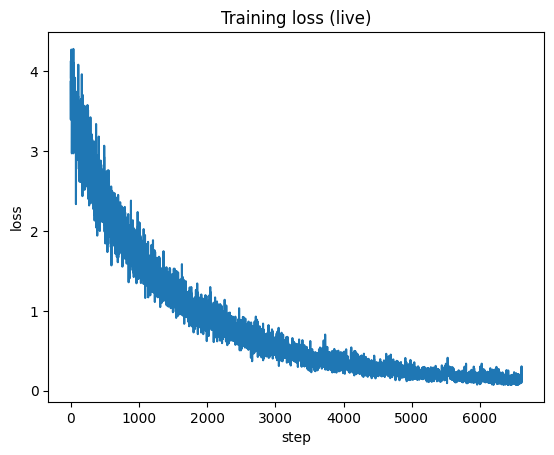

Stage2 epoch 2/2: 100%|██████████| 3334/3334 [09:00<00:00,  6.17it/s, loss=0.246]


Epoch 2: avg loss = 0.245612
[ckpt] sauvegardé: /content/DinOV2with1epochsImages518with1Layers/last.pt


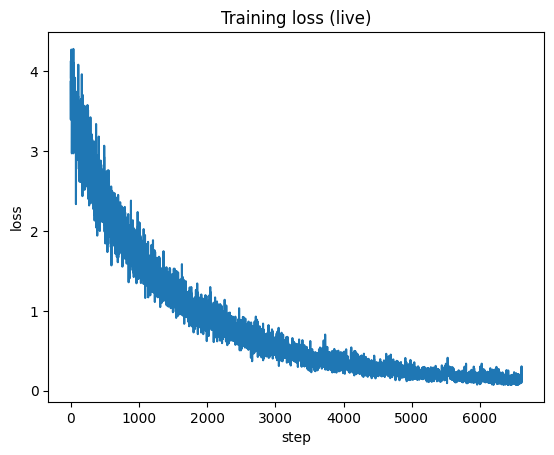

In [13]:
matcher = CorrespondenceMatcher2(extractor)
matcher.ckpt_dir = "/content"
matcher.exp_name = "SAMwith1epochsImages512with1Layers"   # optionnel
matcher.resume = True                   # optionnel
matcher.save_every_epoch = 1            # optionnel
from fine_tunning.test import train_stage2
matcher = train_stage2(
    matcher=matcher,
    train_loader=train_loader,
    n_epochs=2,            # 1-3
    n_last_blocks=1,       # 1 sur Colab
    lr=2e-5,
    weight_decay=0.01,
    tau=0.07,
    max_batches_per_epoch=3000000,  # pour limiter le temps (optionnel)
    use_amp=True,isSam=False
)

# 3) Evaluation (metrics generation)

---



Loading SPair-71k test annotations...


Evaluating: 100%|██████████| 765/765 [07:42<00:00,  1.65it/s]



EVALUATION SUMMARY

📊 Overall PCK:
----------------------------------------------------------------------
  PCK@0.05: 29.69%
  PCK@0.10: 42.63%
  PCK@0.15: 51.11%
  PCK@0.20: 57.34%

📁 Per-Category PCK:
----------------------------------------------------------------------
  aeroplane       → 0.05: 30.81% | 0.10: 39.86% | 0.15: 47.80% | 0.20: 54.27%
  bicycle         → 0.05: 16.48% | 0.10: 25.40% | 0.15: 32.15% | 0.20: 39.32%
  bird            → 0.05: 41.47% | 0.10: 60.74% | 0.15: 71.50% | 0.20: 77.78%
  boat            → 0.05: 19.14% | 0.10: 28.56% | 0.15: 35.65% | 0.20: 41.32%
  bottle          → 0.05: 23.09% | 0.10: 34.29% | 0.15: 42.31% | 0.20: 47.93%
  bus             → 0.05: 31.87% | 0.10: 40.40% | 0.15: 45.38% | 0.20: 49.17%
  car             → 0.05: 28.01% | 0.10: 37.39% | 0.15: 41.40% | 0.20: 45.96%
  cat             → 0.05: 50.08% | 0.10: 60.57% | 0.15: 67.54% | 0.20: 72.57%
  chair           → 0.05: 24.01% | 0.10: 27.96% | 0.15: 32.15% | 0.20: 37.68%
  cow             → 0.0

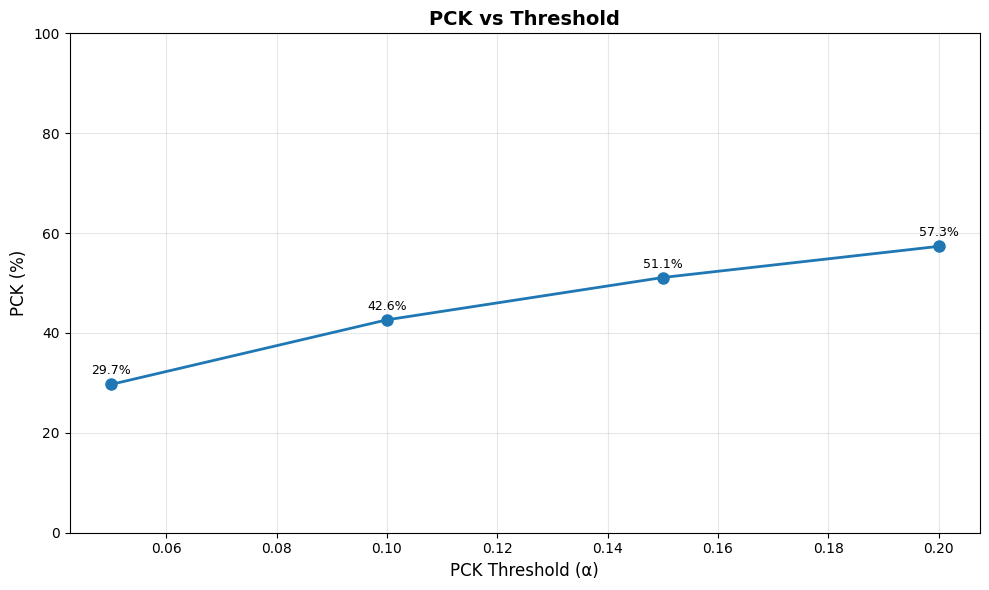

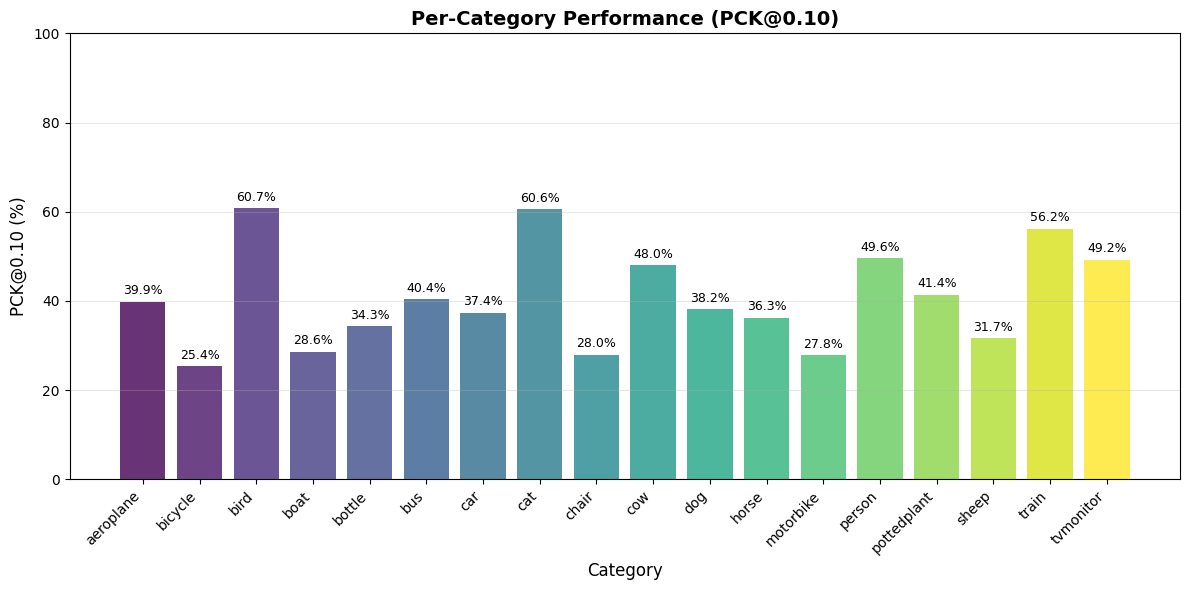

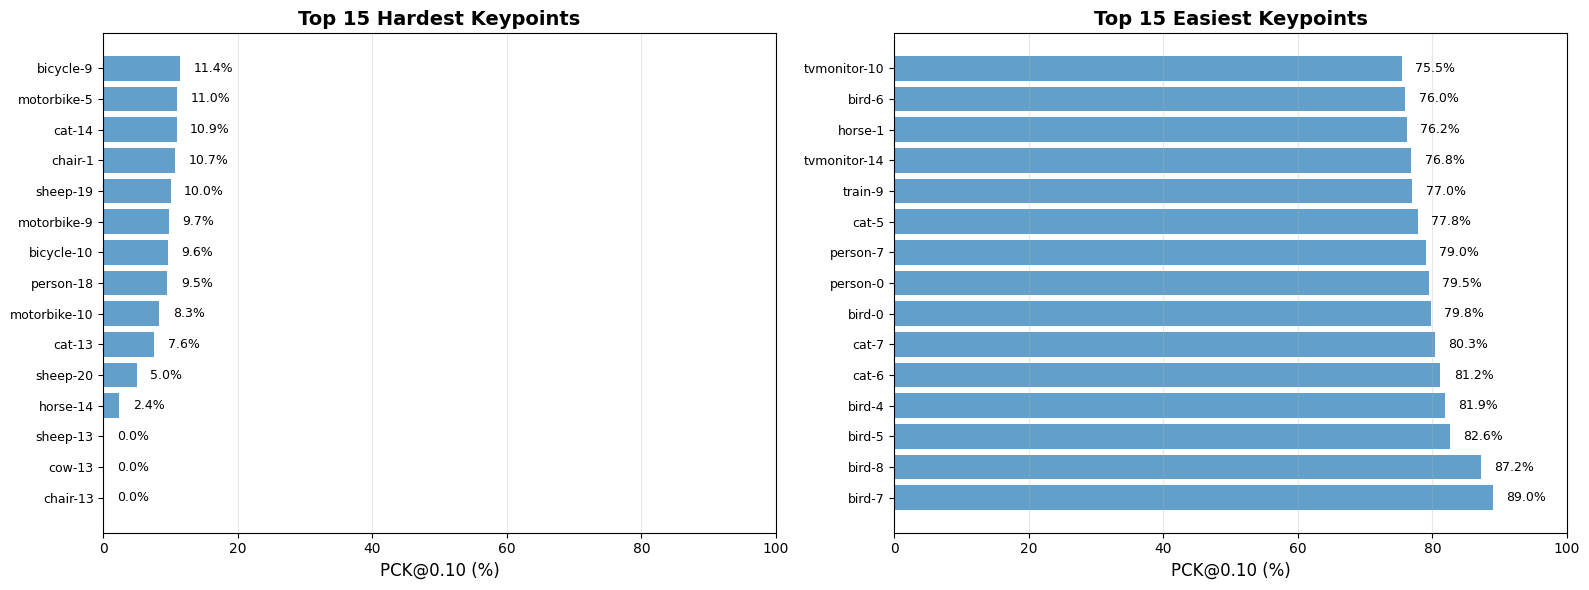

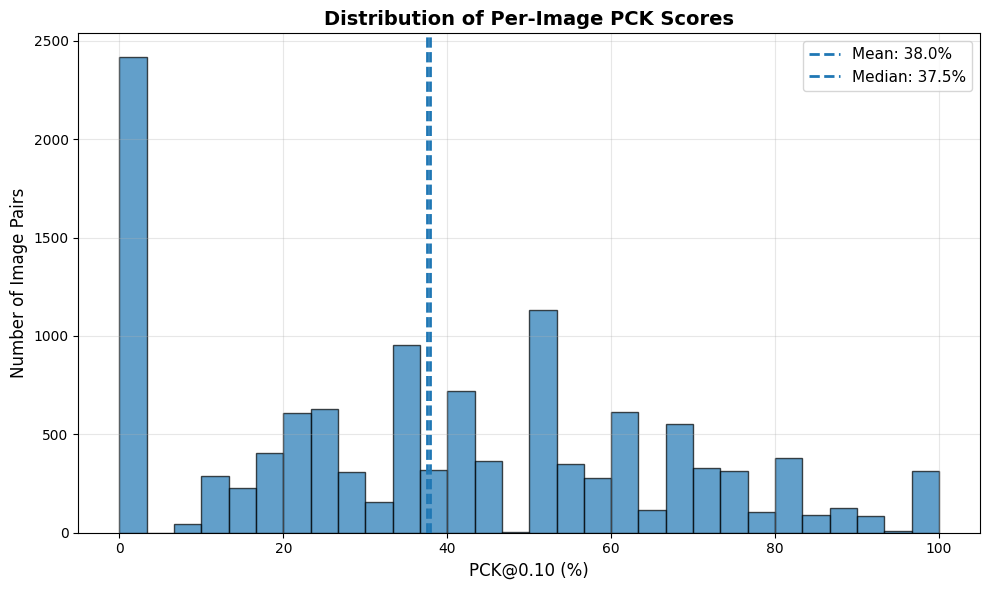

✅ Exported all metrics to ./results/dinov2_vitb14_finetunened/
✅ Report generated in ./results/dinov2_vitb14_finetunened/
   Overall PCK  aeroplane    bicycle      bird       boat     bottle  \
0    42.630876  39.858233  25.400931  60.74057  28.558771  34.288384   

         bus        car        cat      chair        cow       dog      horse  \
0  40.397499  37.388641  60.567925  27.957284  47.984323  38.19242  36.267007   

   motorbike     person  pottedplant      sheep      train  tvmonitor  
0  27.807172  49.581006    41.364039  31.684211  56.224018  49.210455  


In [16]:
# On réutilise le même extractor (poids fine-tunés)
import os
os.chdir("/content")
image_size = 512
matcher_eval = CorrespondenceMatcher(extractor)
dataset = SPairDataset(
        datapath='.',
        split='test',
        img_size=image_size,
        category='all'
    )

dataloader = DataLoader(
    dataset,
    batch_size=16,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn_correspondence
)
metrics_after = evaluate_model(matcher_eval, dataloader,run_name="SAMwith1epochsImages512with1LayersMetrics")
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_name = "dinov2_vitb14"

results_dict = {
    'metrics': metrics_after,
    'model': model_name,
    'timestamp': timestamp
}

with open(f'results_{model_name}_{image_size}_{timestamp}.json', 'w') as f:
    json.dump(results_dict, f, indent=2)

print(f"Results saved!")
analyzer = ResultsAnalyzer(metrics_after)

# Generate full report with all plots and CSVs
analyzer.generate_report(save_dir='./results/dinov2_vitb14_finetunened')

# Export to CSV
# analyzer.export_to_csv(save_dir='./results')

# Create summary table
summary_df = analyzer.create_summary_table(threshold=0.10)
print(summary_df)